閾値決定手法の紹介
===

In [164]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
IMG_DIR = "./sample_img/"

## 画像の読み込み

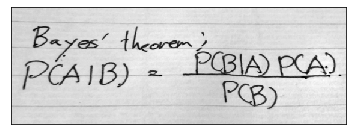

In [2]:
# グレースケール画像で読み込み
img = cv2.imread('img/main.png',0)
plt.imshow(img,cmap = "gray")
plt.xticks([])
plt.yticks([])
plt.show()

## ヒストグラムの表示

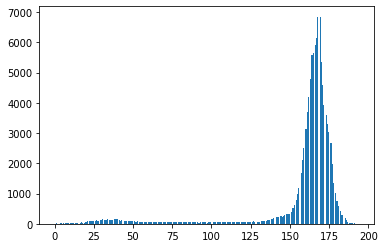

In [3]:
data = img.reshape(-1)
plt.hist(data,bins=256)
ax1.set_ylabel('Number of data [num]')
ax2.set_ylabel('$\sigma_b^2$')
plt.savefig(IMG_DIR + 'hist_otsu.png')
plt.show()

## K-means
特徴
 - 教師なし学習はとりあえずこれ
 - 多次元への拡張が容易

In [4]:
# ラベルの初期化
labels = np.random.randint(0,2,data.shape[0])

# 終了条件
OPTIMIZE_EPSILON = 1

m_0_old = -np.inf
m_1_old = np.inf

for i in range(1000):
# それぞれの平均の計算
    m_0 = data[labels==0].mean()
    m_1 = data[labels==1].mean()
# ラベルの再計算
    labels[np.abs(data-m_0) < np.abs(data-m_1)] = 0
    labels[np.abs(data-m_0) >= np.abs(data-m_1)] = 1
#     終了条件
    if np.abs(m_0 - m_0_old) + np.abs(m_1 - m_1_old) < OPTIMIZE_EPSILON:
        break
    m_0_old = m_0
    m_1_old = m_1

print("Optimization Times :{0:}[count]".format(i+1))


Optimization Times :6[count]


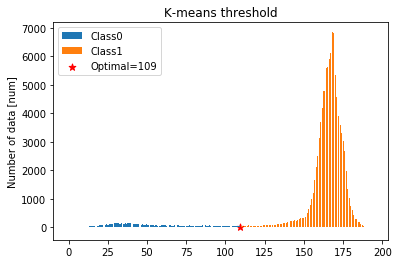

In [5]:
# 初期値によって，クラスが変化するため上界の小さい方を採用
thresh_kmeans = np.minimum(data[labels==0].max(),data[labels==1].max())

plt.hist(data[labels==0],bins=128,label='Class0')
plt.hist(data[labels==1],bins=128,label='Class1')
plt.scatter([thresh_kmeans],[0],s = 50,marker= '*',color = 'red',label='Optimal={0:d}'.format(thresh_kmeans))
plt.title('K-means threshold')
plt.legend()
plt.ylabel('Number of data [num]')
plt.savefig(IMG_DIR + 'hist_kmeans.png')
plt.show()

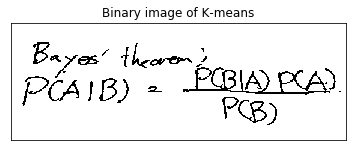

In [240]:
plt.imshow(img>thresh_kmeans,cmap = 'gray')
plt.xticks([])
plt.yticks([])
plt.title("Binary image of K-means")
plt.savefig(IMG_DIR + 'img_kmeans.png')



## 大津法(Otsu's method)
特徴：
- 計算が簡単
- ヒストグラムに変える必要がないため，binsなどの設定に依存しない


In [7]:
# Define Otsu scoring function
def OtsuScore(data,thresh):
    w_0 = np.sum(data<=thresh)/data.shape[0]
    w_1 = np.sum(data>thresh)/data.shape[0]
    # check ideal case    
    if (w_0 ==0) | (w_1 == 0):
        return 0
    mean_all = data.mean()
    mean_0 = data[data<=thresh].mean()
    mean_1 = data[data>thresh].mean()
    sigma2_b =  w_0 *((mean_0 - mean_all)**2) + w_1 *((mean_1 - mean_all)**2)

    return sigma2_b



In [8]:
# Callculation of Otsu score and analyze the optimal
scores_otsu =  np.zeros(256)
for i in range(scores_otsu.shape[0]):
    scores_otsu[i] = OtsuScore(data,i)
thresh_otsu = np.argmax(scores_otsu)

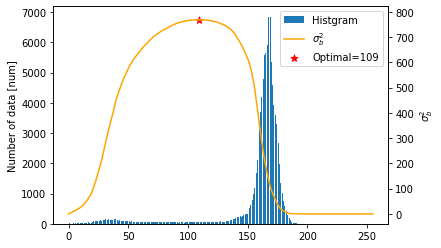

In [9]:
# visualization 
fig = plt.figure()
ax1 = fig.add_subplot()
ax2 = ax1.twinx()
ax1.hist(data,bins=256,label='Histgram')
ax2.plot(scores_otsu,label='$\sigma_b^2$',color = 'orange')
ax2.scatter([thresh_otsu],[scores_otsu[thresh_otsu]],s = 50,marker= '*',color = 'red',label='Optimal={0:d}'.format(thresh_otsu))
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1+h2, l1+l2)
ax1.set_ylabel('Number of data [num]')
ax2.set_ylabel('$\sigma_b^2$')
plt.savefig(IMG_DIR + 'hist_otsu.png')
plt.show()


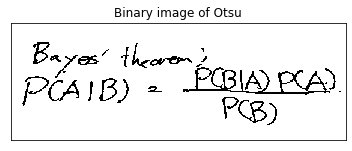

In [239]:
plt.imshow(img>thresh_otsu,cmap = 'gray')
plt.xticks([])
plt.yticks([])
plt.title("Binary image of Otsu")
plt.savefig(IMG_DIR + 'img_otsu.png')


## Sezanによる手法
特徴：
 - 調整するハイパーパラメータが多いが状況に合わせて使い分けることができる
 - 多次元化が難しい


In [157]:
# 平滑化パラメータ
sigma = 5.0

# 重要視する割合 
# gamma = 1 : 黒の領域を広めに取る
# gamma = 0 : 白の領域を広めに取る
gamma = 0.5

In [158]:
# 平滑化のためのガウスカーネル
def getGaus(G_size,G_sigma):
    G_kernel = np.zeros(G_size)
    G_i0 = G_size//2
    for i in range(G_size):
        G_kernel[i] = np.exp(-(i-G_i0)**2 / (2*G_sigma**2))
#     和が1になるように調整
    G_kernel = G_kernel/G_kernel.sum()

    return G_kernel

kernel = getGaus(55,sigma)

In [159]:
# ヒストグラム化
num_hist, range_hist = np.histogram(data, bins= 256)
mean_hist = (range_hist[1:] + range_hist[:-1]) / 2

# 平滑化
hist_bar = np.convolve(num_hist,kernel,'same')
# 差分の計算
d_hist = hist_bar[:-1] - hist_bar[1:]
# 端の処理
d_hist = np.r_[[0],d_hist,[0]]

# ピーク検出 
m = np.where((d_hist[1:] >=0) & (d_hist[:-1] <=0))[0]
#  局地検出
es =np.where((d_hist[1:] <=0) & (d_hist[:-1] >=0))[0]

# 最大ピークと最小ピーク
m0 = m.min()
m1 = m.max()

# ピーク前後の局地
s0 = es[es<m0].max()
e0 = es[es>m0].min()
s1 = es[es<m1].max()
e1 = es[es>m1].min()

# 閾値決定
thresh_Sezan = (1 - gamma) * mean_hist[e0] + gamma * mean_hist[s1]




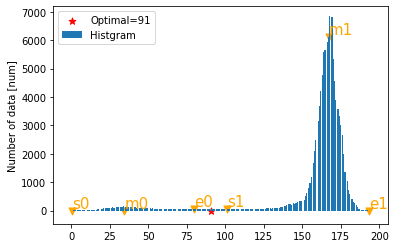

In [160]:
fig = plt.figure()
plt.bar(mean_hist,num_hist,label='Histgram')
plt.scatter(mean_hist[[s0,m0,e0,s1,m1,e1]],num_hist[[s0,m0,e0,s1,m1,e1]],s = 50,marker= 'v',color = 'orange')
plt.text(mean_hist[s0], num_hist[s0]+100,'s0',fontsize = 15.0,color = 'orange')
plt.text(mean_hist[s1], num_hist[s1]+100,'s1',fontsize = 15.0,color = 'orange')
plt.text(mean_hist[m0], num_hist[m0]+100,'m0',fontsize = 15.0,color = 'orange')
plt.text(mean_hist[m1], num_hist[m1]+100,'m1',fontsize = 15.0,color = 'orange')
plt.text(mean_hist[e0], num_hist[e0]+100,'e0',fontsize = 15.0,color = 'orange')
plt.text(mean_hist[e1], num_hist[e1]+100,'e1',fontsize = 15.0,color = 'orange')
plt.scatter([thresh_Sezan],[0],s = 50,marker= '*',color = 'red',label='Optimal={0:.0f}'.format(thresh_Sezan))
plt.legend()
plt.ylabel('Number of data [num]')
plt.savefig(IMG_DIR + 'hist_Sezan.png')
plt.show()



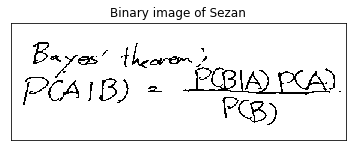

In [238]:
plt.imshow(img>thresh_Sezan,cmap = 'gray')
plt.xticks([])
plt.yticks([])
plt.title("Binary image of Sezan")
plt.savefig(IMG_DIR + 'img_Sezan.png')

## カルバック・ライブラー情報量最小化
特徴
- データの特徴に依存しない(画像だと，バックグラウンドとシグナルの山が2つあるなど)
- binsを細かくすると，確率pが正しく構成できないため注意

In [211]:
def InfoScore(data,thresh,bins=100):
    num_hist, range_hist = np.histogram(data, bins= bins)
    mean_hist = (range_hist[1:] + range_hist[:-1]) / 2
    p = num_hist/num_hist.sum()
    N = p.shape[0]
    M = np.sum(mean_hist>thresh)
    if (M== 0):
        return np.inf
    q = np.zeros(N)
    q[mean_hist>thresh] = 1 / M
    Dqp = - np.log(M)  - np.sum(q*np.log(p))
    return Dqp

In [218]:
# Callculation of Otsu score and analyze the optimal
scores_info =  np.zeros(256)
for i in range(scores_info.shape[0]):
    scores_info[i] = InfoScore(data,i,bins = 190)
thresh_info = np.argmin(scores_info)

In [219]:
# making p and q at optimal threshold
num_hist, range_hist = np.histogram(data, bins= 190)
mean_hist = (range_hist[1:] + range_hist[:-1]) / 2
p = num_hist/num_hist.sum()
N = p.shape[0]
M = np.sum(mean_hist>thresh_info)
q = np.zeros(N)
q[mean_hist>thresh_info] = 1 / M



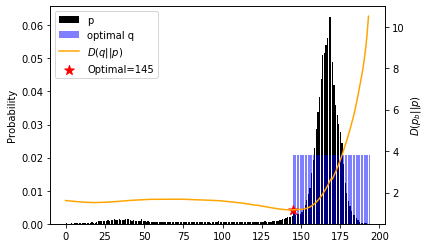

In [220]:
# visualization 
fig = plt.figure()
ax1 = fig.add_subplot()
ax2 = ax1.twinx()
ax1.bar(mean_hist,p,color = 'black',label = 'p')
ax1.bar(mean_hist,q,color = 'blue',label = 'optimal q',alpha = 0.5)
ax2.plot(scores_info,label='$D(q||p)$',color = 'orange')
ax2.scatter([thresh_info],[scores_info[thresh_info]],s = 100,marker= '*',color = 'red',label='Optimal={0:d}'.format(thresh_info))
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1+h2, l1+l2)
ax1.set_ylabel('Probability')
ax2.set_ylabel('$D(p_b||p)$')
plt.savefig(IMG_DIR + 'hist_info.png')
plt.show()

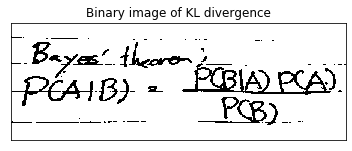

In [254]:
plt.imshow(img>thresh_info,cmap = 'gray')
plt.xticks([])
plt.yticks([])
plt.title("Binary image of KL divergence")
plt.savefig(IMG_DIR + 'img_info.png')

## まとめ

In [272]:
df =pd.DataFrame(np.array([[thresh_kmeans,thresh_otsu,thresh_Sezan,thresh_info]]),columns =['K-means','Otsu','Sezan','KL divergence'],index=['Threshold'])
df.to_csv('Threshold.csv')
df

,K-means,Otsu,Sezan,KL divergence
Threshold,109.0,109.0,90.558594,145.0


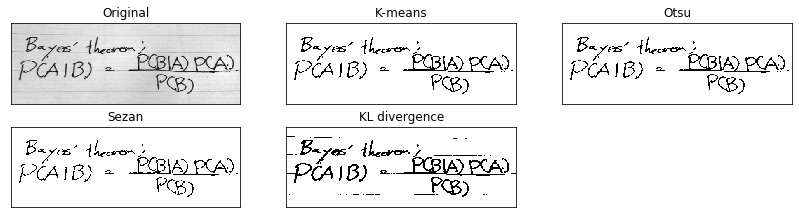

In [266]:
plt.figure(figsize=(14,3.5))
plt.subplot(2,3,1)
plt.imshow(img,cmap = "gray")
plt.xticks([])
plt.yticks([])
plt.title("Original")
plt.subplot(2,3,2)
plt.imshow(img>thresh_kmeans,cmap = 'gray')
plt.xticks([])
plt.yticks([])
plt.title("K-means")
plt.subplot(2,3,3)
plt.imshow(img>thresh_otsu,cmap = 'gray')
plt.xticks([])
plt.yticks([])
plt.title("Otsu")
plt.subplot(2,3,4)
plt.imshow(img>thresh_Sezan,cmap = 'gray')
plt.xticks([])
plt.yticks([])
plt.title("Sezan")
plt.subplot(2,3,5)
plt.imshow(img>thresh_info,cmap = 'gray')
plt.xticks([])
plt.yticks([])
plt.title("KL divergence")
plt.savefig(IMG_DIR + 'img_all.png')